<a href="https://colab.research.google.com/github/Michal-Janulewski/Uczenie-Maszynowe-w-Finansach/blob/Quiz-3/Quiz_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalacja brakujących bibliotek
!pip install yfinance backtrader

import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import backtrader as bt
import matplotlib.pyplot as plt

# Magiczna komenda do poprawnego wyświetlania wykresów w Colab
%matplotlib inline

# Funkcje pomocnicze do obliczania wskaźników technicznych
def compute_RSI(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

def compute_MACD(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    MACD = short_ema - long_ema
    signal = MACD.ewm(span=signal_window, adjust=False).mean()
    return MACD, signal

# Pobranie danych historycznych dla spółki Apple
ticker = "AAPL"
start_date = "2024-01-01"
end_date = "2024-05-06"
data = yf.download(ticker, start=start_date, end=end_date)

# Obliczenie wskaźników technicznych
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['RSI'] = compute_RSI(data['Close'], window=14)
data['MACD'], data['MACD_signal'] = compute_MACD(data['Close'])

# Usunięcie NA
data = data.dropna()

# Przygotowanie cech i etykiet
X = data[['SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_signal']]
y = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)  # 1: Kup, 0: Sprzedaj

# Podział danych na zbiór treningowy i testowy
split = int(len(data) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Stworzenie modelu RandomForest i optymalizacja hiperparametrów
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Najlepszy model
best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Ocena modelu na zbiorze testowym
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

# Przewidywanie sygnałów na całym zbiorze danych
data.loc[:, 'signal'] = best_model.predict(X)

# Wyświetlenie sygnałów
print(data[['signal']])

# Przeprowadzenie backtestu
class MLStrategy(bt.Strategy):
    def __init__(self):
        self.data_close = self.datas[0].close
        self.signal = data['signal']

    def next(self):
        if self.signal.iloc[len(self) - 1] == 1:
            if not self.position:
                self.buy()
        elif self.signal.iloc[len(self) - 1] == 0:
            if self.position:
                self.sell()

cerebro = bt.Cerebro()
cerebro.addstrategy(MLStrategy)
data_bt = bt.feeds.PandasData(dataname=data)
cerebro.adddata(data_bt)
cerebro.broker.set_cash(10000)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trade_analyzer")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe_ratio")
cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")


In [20]:
# Uruchomienie backtestu i wyświetlenie wyników
results = cerebro.run()

# Wyniki backtestu
strat = results[0]

# Analiza wyników
trade_analyzer = strat.analyzers.trade_analyzer.get_analysis()
sharpe_ratio = strat.analyzers.sharpe_ratio.get_analysis()
returns_analyzer = strat.analyzers.returns.get_analysis()

# Wyciągnięcie wartości z analizatora Returns
total_return = returns_analyzer['rtot']
annualized_return = returns_analyzer['rnorm']

In [19]:
# Podsumowanie wyników
summary = {
    'Total Trades': trade_analyzer.total.closed,
    'Winning Trades': trade_analyzer.won.total,
    'Losing Trades': trade_analyzer.lost.total,
    'Win Rate (%)': (trade_analyzer.won.total / trade_analyzer.total.closed) * 100 if trade_analyzer.total.closed > 0 else 0,
    'Sharpe Ratio': sharpe_ratio['sharperatio'] if 'sharperatio' in sharpe_ratio else None,
    'Total Return (%)': total_return * 100,  # Zmiana na procenty
    'Annualized Return (%)': annualized_return * 100,  # Zmiana na procenty
}

summary_df = pd.DataFrame(summary, index=[0])
print(summary_df)

   Total Trades  Winning Trades  Losing Trades  Win Rate (%) Sharpe Ratio  \
0             9               6              3     66.666667         None   

   Total Return (%)  Annualized Return (%)  
0          2.632057              19.633703  


<Figure size 1000x600 with 0 Axes>

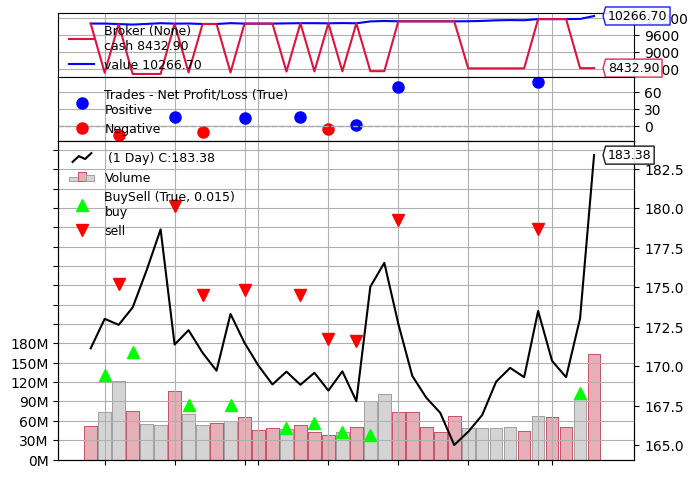

In [21]:
# Wizualizacja wyników backtestu
%matplotlib inline
plt.figure(figsize=(10, 6))
cerebro.plot(iplot=False)
plt.show()

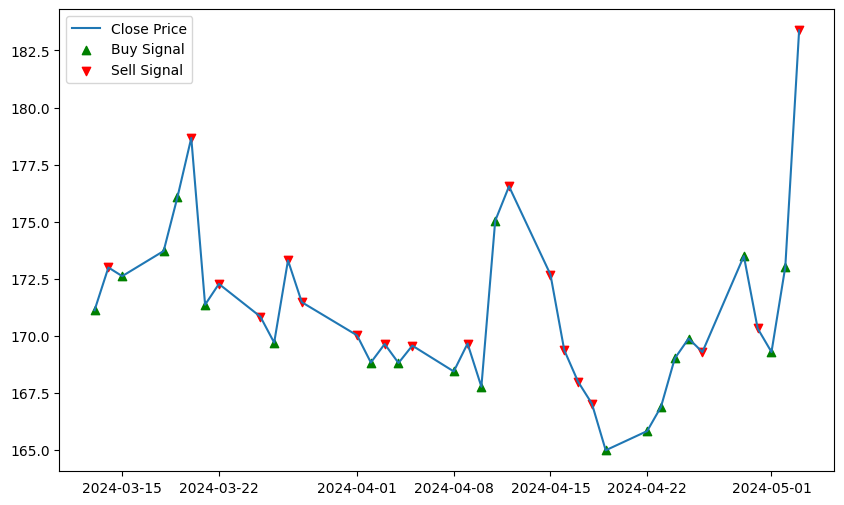

In [11]:
# Wizualizacja sygnałów kupna i sprzedaży
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='Close Price')
buy_signals = data[data['signal'] == 1]
sell_signals = data[data['signal'] == 0]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal')
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal')
plt.legend()
plt.show()